# Segmentação e estimação da potência de painéis solares utilizando imagens de satélite
---
# Solar Panel Segmentation and Power Estimation Using Satellite Imagery

## Library Imports

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import sklearn.model_selection
import sklearn.utils.class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

## Inputs

In [ ]:
# https://drive.google.com/drive/folders/1Jca80MO1lM_8Jb6cTlM9RcwiVCRQd7td?usp=sharing

In [ ]:
!unzip "/content/gdrive/My Drive/bdappv/google.zip" -d "/content/google"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/google/google/mask/QHIAP38B1OQXHG.png  
  inflating: /content/google/google/mask/QHLDY4A6ETCDAM.png  
  inflating: /content/google/google/mask/QHLIM66FCBNAVK.png  
  inflating: /content/google/google/mask/QHOMD851ODKGB.png  
  inflating: /content/google/google/mask/QHQCO975ORSEZ.png  
  inflating: /content/google/google/mask/QHTQU7A89XWVTI.png  
  inflating: /content/google/google/mask/QHULK2D8FMPRAG.png  
  inflating: /content/google/google/mask/QHVQJ5C28CGFWB.png  
  inflating: /content/google/google/mask/QHWOU368FVUUWP.png  
  inflating: /content/google/google/mask/QHXTJ4A2FFGYDW.png  
  inflating: /content/google/google/mask/QHZMA4606HSZYM.png  
  inflating: /content/google/google/mask/QIAXX380BVXLXI.png  
  inflating: /content/google/google/mask/QIDNA17ACPTHFF.png  
  inflating: /content/google/google/mask/QIDUX76C1RXYML.png  
  inflating: /content/google/google/mask/QIDWL4B16FEJVM.png  
  inflating: 

In [ ]:
# Define the paths for the image and mask folders
image_folder = '/content/google/google/img'
mask_folder = '/content/google/google/mask'
black_mask = '/content/google/google/black_mask/black_mask.png'

## Fuctions

### Loading & Pre-processing

In [ ]:
def load_and_preprocess_image(path, size=400):
    """
    Loads and preprocesses an image from the given file path.

    Args:
        path (str): File path of the image to be loaded and preprocessed.
        size (int): Desired size for resizing the image (both height and width).

    Returns:
        tf.Tensor: Preprocessed image tensor ready for further processing or analysis.
                   The tensor has the shape (height, width, channels) and the pixel values are normalized to the range [0, 1].
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [size, size])
    image /= 255.0
    return image


def load_and_preprocess_mask(path, size=400):
    """
    Loads and preprocesses a mask from the given file path.

    Args:
        path (str): File path of the mask to be loaded and preprocessed.
        size (int): Desired size for resizing the mask (both height and width).

    Returns:
        tf.Tensor: Preprocessed mask tensor ready for further processing or analysis.
                   The tensor has the shape (height, width, 1) and the pixel values are normalized to the range [0, 1].
    """
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [size, size])
    mask /= 255.0
    return mask


def count_black_masks(mask_dataset):
    """
    Counts the number of black masks in a given mask dataset.

    Args:
        mask_dataset (tf.data.Dataset): Dataset of masks.

    Returns:
        int: Number of black masks.
    """
    num_black_masks = 0
    for mask in mask_dataset:
        if tf.reduce_all(mask == 0):
            num_black_masks += 1
    return num_black_masks

def data_generator(image_files, mask_files, batch_size):
    """
    Generates batches of preprocessed image and mask data.

    Args:
        image_files (list): List of image file paths.
        mask_files (list): List of mask file paths.
        batch_size (int): Batch size.

    Yields:
        tuple: A tuple containing the batch of image data and mask data as NumPy arrays.
    """
    while True:
        # Create a list of indices and shuffle it
        idx = np.arange(len(image_files))
        np.random.shuffle(idx)

        for i in range(0, len(image_files), batch_size):
            # Get the indices of the current batch
            batch_idx = idx[i:i+batch_size]

            # Initialize lists for this batch
            batch_images = []
            batch_masks = []

            for j in batch_idx:
                image = load_and_preprocess_image(image_files[j])
                mask = load_and_preprocess_mask(mask_files[j])

                batch_images.append(image)
                batch_masks.append(mask)

            # Convert lists to NumPy arrays and yield them
            yield np.array(batch_images), np.array(batch_masks)


### Plots

In [ ]:
def plot_images_and_masks(train_image_dataset, train_mask_dataset, num_samples=5):
    """
    Plots a grid of images and corresponding masks.

    Args:
        train_image_dataset (tf.data.Dataset): Dataset of training images.
        train_mask_dataset (tf.data.Dataset): Dataset of corresponding masks.
        num_samples (int): Number of samples to plot (default: 5).
    """
    plt.figure(figsize=(15, 10))
    for i, (image, mask) in enumerate(zip(train_image_dataset.take(num_samples), train_mask_dataset.take(num_samples))):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Image')
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(np.squeeze(mask), cmap='gray')
        plt.axis('off')
        plt.title('Mask')
    plt.show()

def plot_sample_distribution(total_samples, masked_samples, unmasked_samples):
    """
    Plots a bar chart showing the distribution of masked and unmasked samples in different datasets.

    Args:
        total_samples (list): List of total samples in each dataset.
        masked_samples (list): List of masked samples in each dataset.
        unmasked_samples (list): List of unmasked samples in each dataset.
    """
    masked_percentages = [100 * m / t for m, t in zip(masked_samples, total_samples)]
    unmasked_percentages = [100 * u / t for u, t in zip(unmasked_samples, total_samples)]
    total_percentages = [100 * t / sum(total_samples) for t in total_samples]

    labels = ['Training', 'Validation', 'Test']
    x = np.arange(len(labels))
    width = 0.3
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, total_samples, width, label='Total')
    rects2 = ax.bar(x + width/2, masked_samples, width, label='With mask')
    rects3 = ax.bar(x + width/2, unmasked_samples, width, bottom=masked_samples, label='Without mask')

    for i, rect in enumerate(rects1):
        ax.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height() + 5,
                f"{masked_percentages[i]:.1f}% masked\n{unmasked_percentages[i]:.1f}% unmasked\n{total_percentages[i]:.1f}% of total",
                ha='center')

    ax.set_ylabel('Number of samples')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

def visualize_predictions(model, test_dataset, num_images=5):
    """
    Visualizes the predictions of a segmentation model on a test dataset.

    Args:
        model (tf.keras.Model): Segmentation model.
        test_dataset (tf.data.Dataset): Test dataset.
        num_images (int): Number of images to visualize (default: 5).
    """
    # Get the specified number of samples from the test dataset
    samples = list(test_dataset.take(num_images).as_numpy_iterator())

    # Create subplots to display the images
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))

    # Iterate over the samples and visualize the images, ground truth masks, and predicted masks
    for i, sample in enumerate(samples):
        image = sample[0]
        mask = sample[1]

        # Make predictions with the model
        prediction = model.predict(np.expand_dims(image, axis=0))
        predicted_mask = (prediction[0] > 0.5).astype(np.uint8)

        # Plot the images and masks
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original Image')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')

        axes[i, 2].imshow(predicted_mask, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

def plot_loss(model):
    """
    Plots the training and validation loss over epochs for a given model.

    Args:
        model (tf.keras.Model): The trained model.

    Returns:
        None
    """
    # Get the loss values from the model's history
    training_loss = model.history.history['loss']
    validation_loss = model.history.history['val_loss']
    
    # Plot the loss values
    plt.figure(figsize=(12, 6))
    plt.plot(training_loss, label='Training loss')
    plt.plot(validation_loss, label='Validation loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)  # Display grid lines
    plt.legend()
    plt.show()

### Models

In [ ]:
def build_mini_unet(input_shape=(400, 400, 3)):
    """
    Builds a mini UNet segmentation model with fewer parameters.

    Args:
        input_shape (tuple): Input shape of the model (default: (400, 400, 3)).

    Returns:
        tf.keras.Model: Mini UNet segmentation model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up_conv4 = UpSampling2D(size=(2, 2))(drop4)
    up_conv4 = concatenate([conv3, up_conv4], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up_conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    up_conv5 = UpSampling2D(size=(2, 2))(conv5)
    up_conv5 = concatenate([conv2, up_conv5], axis=-1)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up_conv5)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

    up_conv6 = UpSampling2D(size=(2, 2))(conv6)
    up_conv6 = concatenate([conv1, up_conv6], axis=-1)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(up_conv6)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)

    # Output Layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    # Define the model
    model = Model(inputs=inputs, outputs=output)
    

    return model

In [ ]:
def unet(input_shape=(400, 400, 3)):
    """
    Creates a U-Net model architecture.

    Args:
        input_shape (tuple): Input shape of the model (default: (400, 400, 3)).

    Returns:
        tf.keras.Model: U-Net model.
    """

    inputs = Input(shape=input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model

In [ ]:
def conv_block(input, num_filters):
    """
    Constructs a convolutional block consisting of two convolutional layers with batch normalization and ReLU activation.

    Args:
        input (tf.Tensor): Input tensor.
        num_filters (int): Number of filters for the convolutional layers.

    Returns:
        tf.Tensor: Output tensor.
    """

    # Source: [https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/resnet50_unet.py] 

    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    """
    Constructs a decoder block consisting of a transposed convolutional layer, concatenation, and a convolutional block.

    Args:
        input (tf.Tensor): Input tensor.
        skip_features (tf.Tensor): Skip connection features from the encoder.
        num_filters (int): Number of filters for the convolutional layers.

    Returns:
        tf.Tensor: Output tensor.
    """
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """
    Builds a U-Net model with a pre-trained ResNet50 encoder.

    Args:
        input_shape (tuple): Input shape of the model (default: (400, 400, 3)).

    Returns:
        tf.keras.Model: U-Net model.
    """
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder
    s1 = resnet50.get_layer("input_1").output           # (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        # (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  # (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  # (64 x 64)
    # Bridge
    b1 = resnet50.get_layer("conv4_block6_out").output  # (32 x 32)
    # Decoder
    d1 = decoder_block(b1, s4, 512)                     # (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     # (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     # (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      # (512 x 512)

    # Output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")

    return model

### Metrics

In [ ]:
def evaluate_dice(model, test_dataset, batch_size=16):
    """
    Evaluates the Dice coefficient of a segmentation model on a test dataset.

    Args:
        model (tf.keras.Model): Segmentation model.
        test_dataset (tf.data.Dataset): Test dataset.
        batch_size (int): Batch size for evaluation (default: 16).

    Returns:
        float: Average Dice coefficient score.
    """
    dice_scores = []
    
    test_dataset_batched = test_dataset.batch(batch_size)
    
    for images, masks in test_dataset_batched:
        images = images.numpy()
        masks = masks.numpy()
        
        try:
            predictions = model.predict(images, verbose=0)
        except Exception as e:
            print(f"Error occurred during prediction: {e}")
            continue

        for j in range(images.shape[0]):
            predicted_mask = (predictions[j] > 0.5).astype(np.uint8)
            
            mask_flat = masks[j].flatten()
            predicted_mask_flat = predicted_mask.flatten()

            intersection = np.sum(mask_flat * predicted_mask_flat)
            union = np.sum(mask_flat) + np.sum(predicted_mask_flat) 

            if union == 0:
                if intersection == 0:
                    dice_score = 1.0  # Perfect match when both intersection and union are zero
                else:
                    dice_score = 0.0  # No overlap when union is zero
            else:
                dice_score = (2 * intersection) / union
            
            dice_scores.append(dice_score)
    
    average_dice = np.mean(dice_scores)
    
    return average_dice


## Main

In [ ]:
# Initialize lists to store file paths
image_files_with_mask = []
image_files_without_mask = []
mask_files_with_mask = []
mask_files_without_mask = []

# Iterate over the files in the image folder
for f in os.listdir(image_folder):
    if f.endswith('.png'):  # Check if the file is a PNG image
        img_path = os.path.join(image_folder, f)  # Get the full image path
        mask_path = os.path.join(mask_folder, f)  # Get the full mask path

        if os.path.exists(mask_path):  # Check if the corresponding mask file exists
            # Append the image and mask paths to the lists with masks
            image_files_with_mask.append(img_path)
            mask_files_with_mask.append(mask_path)
        else:
            # Append the image path to the list without masks and the black mask path to the list of mask files
            image_files_without_mask.append(img_path)
            mask_files_without_mask.append(black_mask)


In [ ]:
# Split the lists containing files with masks into train, test, and validation sets
train_img_files_with_mask, test_img_files_with_mask, train_mask_files_with_mask, test_mask_files_with_mask = sklearn.model_selection.train_test_split(
    image_files_with_mask, mask_files_with_mask, test_size=0.2, random_state=42)

train_img_files_with_mask, val_img_files_with_mask, train_mask_files_with_mask, val_mask_files_with_mask = sklearn.model_selection.train_test_split(
    train_img_files_with_mask, train_mask_files_with_mask, test_size=0.1875, random_state=42)

# Split the lists containing files without masks into train, test, and validation sets
train_img_files_without_mask, test_img_files_without_mask, train_mask_files_without_mask, test_mask_files_without_mask = sklearn.model_selection.train_test_split(
    image_files_without_mask, mask_files_without_mask, test_size=0.2, random_state=42)

train_img_files_without_mask, val_img_files_without_mask, train_mask_files_without_mask, val_mask_files_without_mask = sklearn.model_selection.train_test_split(
    train_img_files_without_mask, train_mask_files_without_mask, test_size=0.1875, random_state=42)

# Combine the training, validation, and test sets from both lists to obtain the final sets
train_img_files = train_img_files_with_mask + train_img_files_without_mask
val_img_files = val_img_files_with_mask + val_img_files_without_mask
test_img_files = test_img_files_with_mask + test_img_files_without_mask
train_mask_files = train_mask_files_with_mask + train_mask_files_without_mask
val_mask_files = val_mask_files_with_mask + val_mask_files_without_mask
test_mask_files = test_mask_files_with_mask + test_mask_files_without_mask


In [ ]:
batch_size = 16  # Make sure to use the correct batch size for your case

# Create the validation image dataset
val_image_dataset = tf.data.Dataset.from_tensor_slices(val_img_files)
val_image_dataset = val_image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_image_dataset = val_image_dataset.batch(batch_size)

# Create the validation mask dataset
val_mask_dataset = tf.data.Dataset.from_tensor_slices(val_mask_files)
val_mask_dataset = val_mask_dataset.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_mask_dataset = val_mask_dataset.batch(batch_size)

# Combine the image and mask datasets
val_dataset = tf.data.Dataset.zip((val_image_dataset, val_mask_dataset))


### Mini U-net

In [ ]:
# Sets the random seeds for reproducibility
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Build the U-Net model with an input shape of (400, 400, 3)
model = build_mini_unet(input_shape=(400, 400, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 400, 400, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
num_epochs = 5

model_path_mini_unet = '/content/gdrive/MyDrive/bdappv/google/model_0.h5'
# callbacks 
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path_mini_unet, verbose=1, save_best_only=True,save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]


# Sets the random seeds for reproducibility
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# Train the model
history = model.fit(
    x=data_generator(train_img_files, train_mask_files, batch_size),
    steps_per_epoch=len(train_img_files) // batch_size,
    verbose = 1,
    epochs=num_epochs,
    validation_data=val_dataset,
    batch_size = batch_size,
    callbacks=callbacks
)

Epoch 1/5
1170/1170 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9726
Epoch 1: val_loss improved from inf to 0.02392, saving model to /content/gdrive/MyDrive/IA901_Projeto_PV/bdappv/google/model_0.h5
1170/1170 [==============================] - 764s 642ms/step - loss: 0.0660 - accuracy: 0.9726 - val_loss: 0.0239 - val_accuracy: 0.9937
Epoch 2/5
1170/1170 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9942
Epoch 2: val_loss did not improve from 0.02392
1170/1170 [==============================] - 709s 605ms/step - loss: 0.0198 - accuracy: 0.9942 - val_loss: 0.0658 - val_accuracy: 0.9938
Epoch 3/5
1170/1170 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9950
Epoch 3: val_loss improved from 0.02392 to 0.01765, saving model to /content/gdrive/MyDrive/IA901_Projeto_PV/bdappv/google/model_0.h5
1170/1170 [==============================] - 703s 601ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.0177 - val_accu

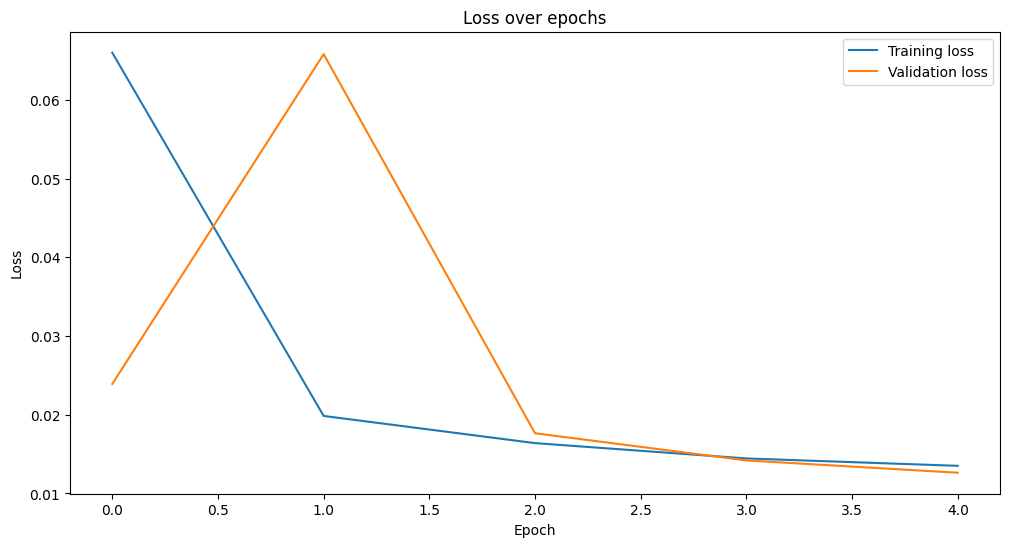

In [ ]:
plot_loss(model)

In [ ]:
# Load the model
model_path  = model_path_mini_unet
model = tf.keras.models.load_model(model_path)

In [ ]:
### Load Test set
test_image_dataset = tf.data.Dataset.from_tensor_slices(test_img_files)
test_image_dataset = test_image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_mask_dataset = tf.data.Dataset.from_tensor_slices(test_mask_files)
test_mask_dataset = test_mask_dataset.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_image_dataset, test_mask_dataset))


1/1 [==============================] - 0s 31ms/step


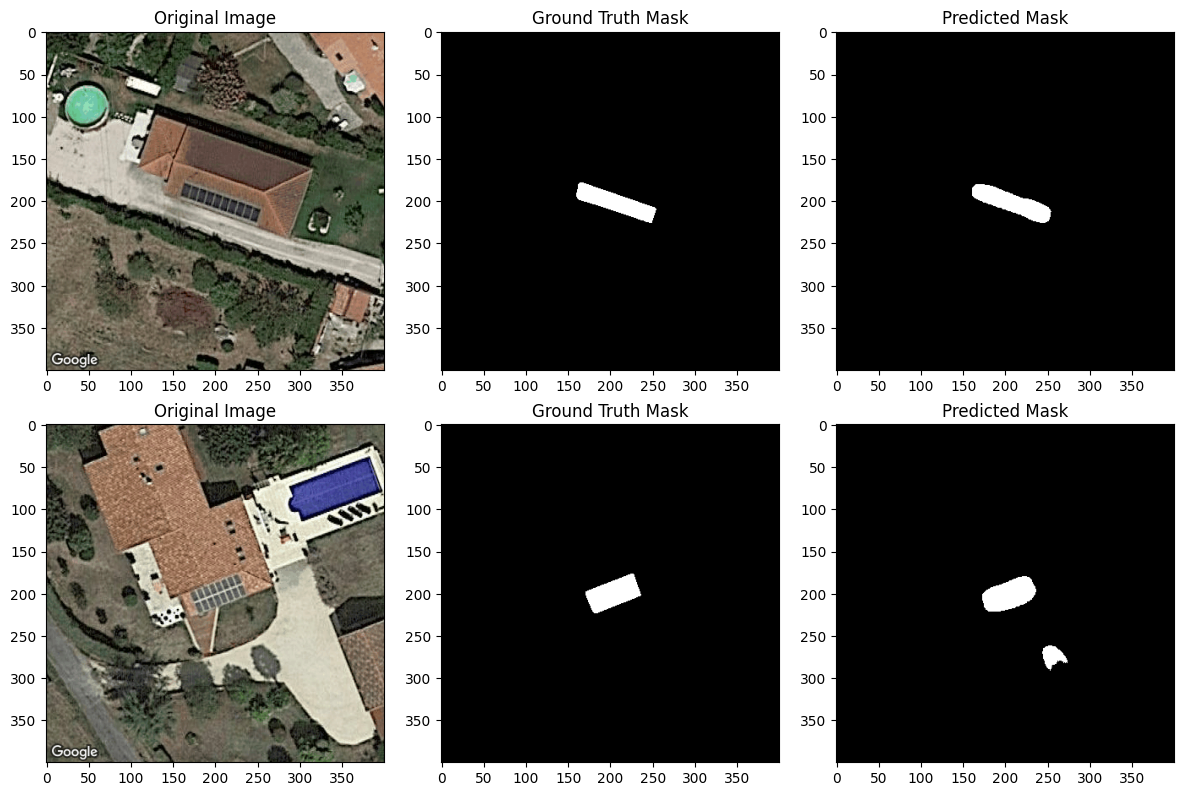

In [ ]:
# Visualize the predicted masks
visualize_predictions(model, test_dataset, num_images=2)

In [ ]:
# Compute dice coefficient
average_dice = evaluate_dice(model, test_dataset)
print("Average DICE score:", average_dice)

Average DICE score: 0.7672812607652637


### Transfer Learning from Resnet50

In [ ]:
# Sets the random seeds for reproducibility
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Build the pretrainde U-Net model with Resnet50 and an input shape of (400, 400, 3)
model_2 = build_resnet50_unet((400, 400, 3))
model_2.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [ ]:
batch_size = 16
num_epochs = 5
model_unet_resnet50 = '/content/gdrive/MyDrive/bdappv/google/model_2.h5'

#Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_unet_resnet50, verbose=1, save_best_only=True,save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Sets the random seeds for reproducibility
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Train the model
history = model_2.fit(
    x=data_generator(train_img_files, train_mask_files, batch_size),
    steps_per_epoch=len(train_img_files) // batch_size,
    verbose = 1,
    epochs=num_epochs,
    validation_data=val_dataset,
    batch_size = batch_size,
    callbacks=callbacks
)

Epoch 1/5
1170/1170 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9866
Epoch 1: val_loss improved from inf to 0.04026, saving model to /content/gdrive/MyDrive/IA901_Projeto_PV/bdappv/google/model_2.h5
1170/1170 [==============================] - 2394s 2s/step - loss: 0.0997 - accuracy: 0.9866 - val_loss: 0.0403 - val_accuracy: 0.9975
Epoch 2/5
1170/1170 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9977
Epoch 2: val_loss improved from 0.04026 to 0.01798, saving model to /content/gdrive/MyDrive/IA901_Projeto_PV/bdappv/google/model_2.h5
1170/1170 [==============================] - 2316s 2s/step - loss: 0.0266 - accuracy: 0.9977 - val_loss: 0.0180 - val_accuracy: 0.9974
Epoch 3/5
1170/1170 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9981
Epoch 3: val_loss improved from 0.01798 to 0.01178, saving model to /content/gdrive/MyDrive/IA901_Projeto_PV/bdappv/google/model_2.h5
1170/1170 [==============================

In [ ]:
## Load the model
model_path  = model_unet_resnet50
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [ ]:
### Test images
test_image_dataset = tf.data.Dataset.from_tensor_slices(test_img_files)
test_image_dataset = test_image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_mask_dataset = tf.data.Dataset.from_tensor_slices(test_mask_files)
test_mask_dataset = test_mask_dataset.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_image_dataset, test_mask_dataset))

1/1 [==============================] - 0s 47ms/step


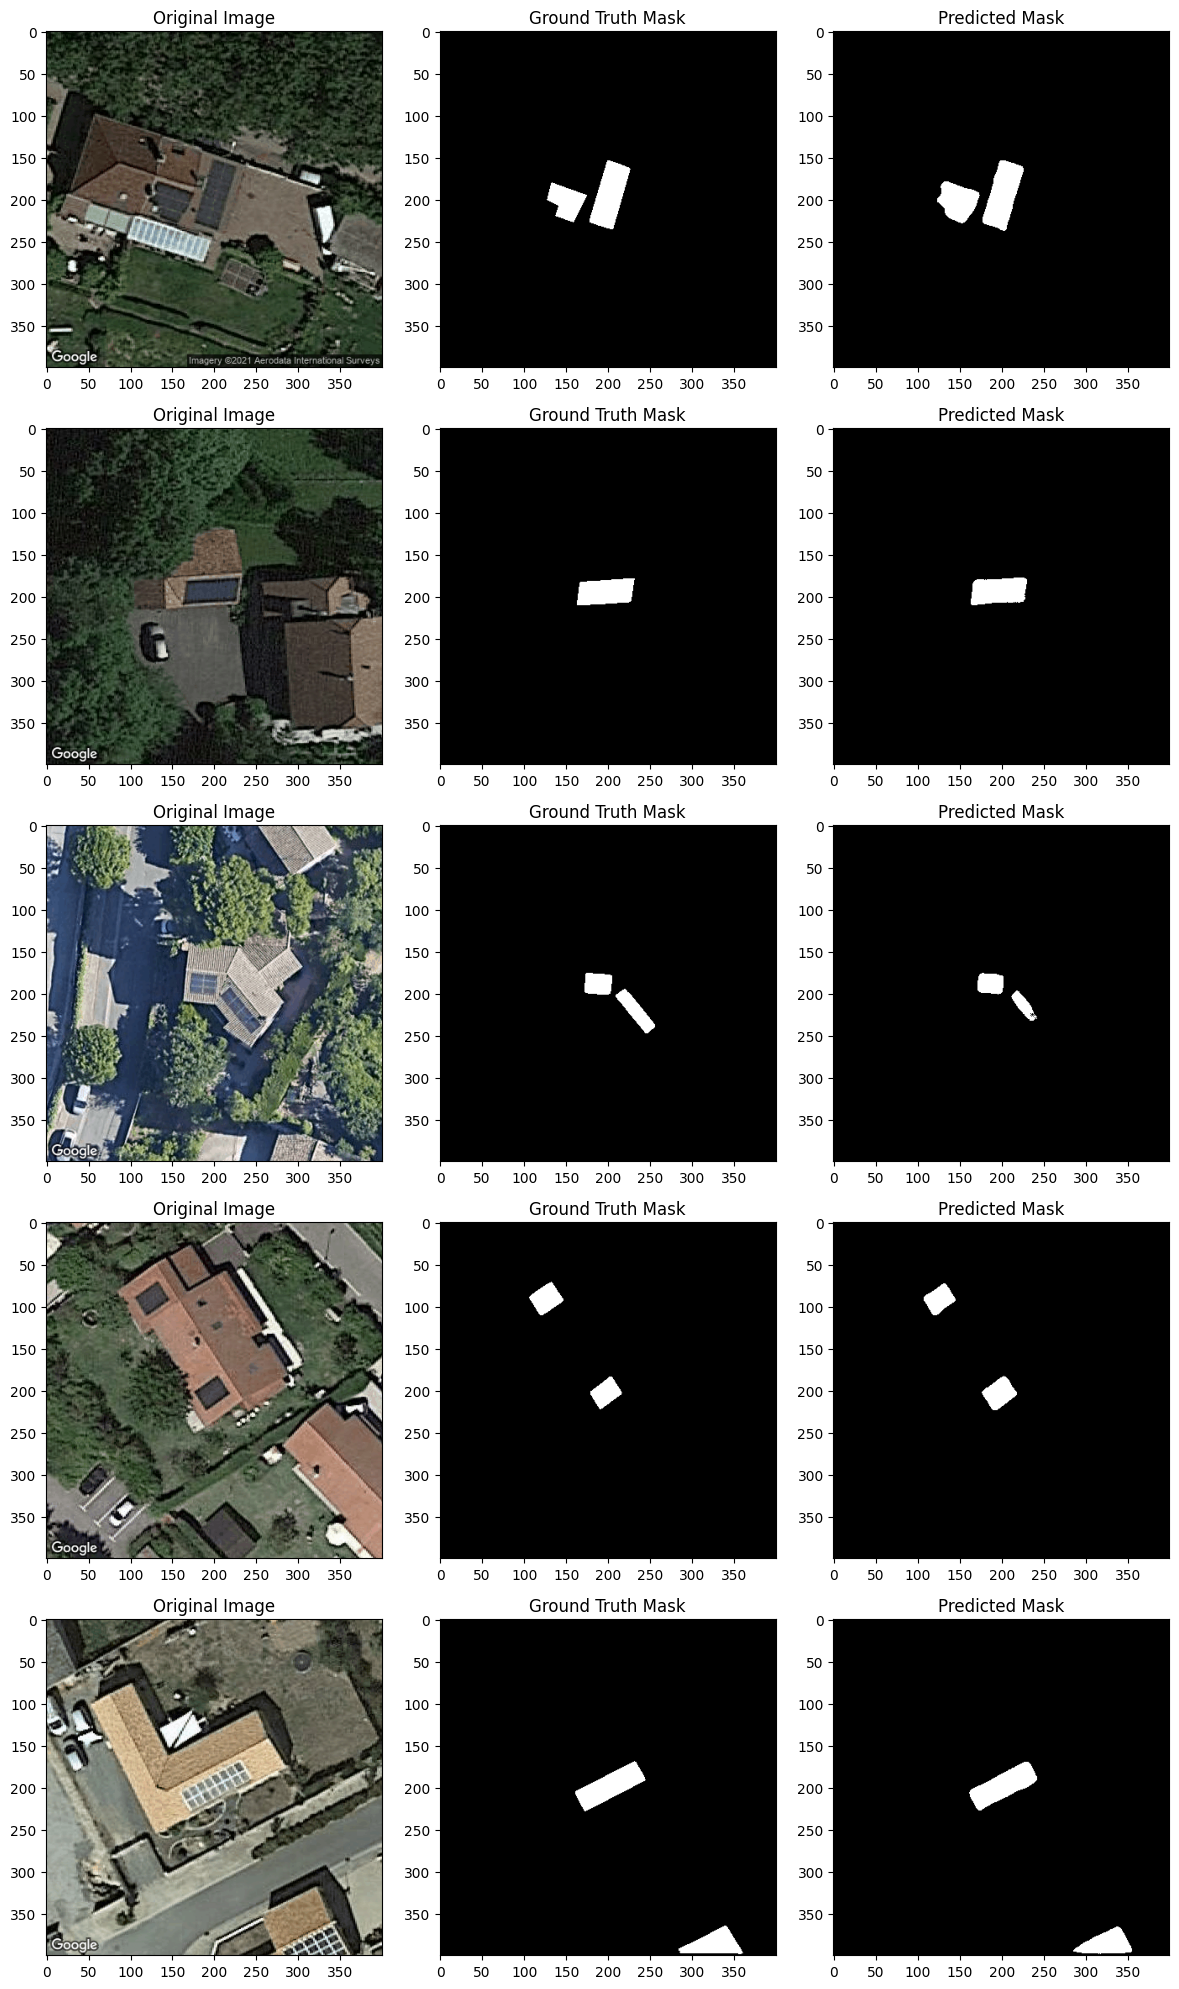

In [ ]:
visualize_predictions(model, test_dataset, num_images=5)

In [ ]:
average_dice = evaluate_dice(model, test_dataset)
print("Average DICE score:", average_dice)

Average DICE score: 0.9330426616364139


## Test in IGN dataset

In [ ]:
db_name = 'ign'

In [ ]:
!unzip "/content/gdrive/My Drive/bdappv/mask.zip" -d "/content/ign"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/ign/mask/JBULG4E79RFAQO.png  
  inflating: /content/ign/mask/JBWSM2376YTTKN.png  
  inflating: /content/ign/mask/JBWYB646ASRXSP.png  
  inflating: /content/ign/mask/JBYPO579AQTCRR.png  
  inflating: /content/ign/mask/JCCHE3B3AQMDHW.png  
  inflating: /content/ign/mask/JCDXN68A5AEKSM.png  
  inflating: /content/ign/mask/JCFJA4104QVWPG.png  
  inflating: /content/ign/mask/JCFXI19CFYTPRX.png  
  inflating: /content/ign/mask/JCIWV8B26MYFFY.png  
  inflating: /content/ign/mask/JCJQG8729LFVCL.png  
  inflating: /content/ign/mask/JCJVH7425QKICU.png  
  inflating: /content/ign/mask/JCLEL236SPSBI.png  
  inflating: /content/ign/mask/JCMOV2CA3LIRNA.png  
  inflating: /content/ign/mask/JCMSG1CF8ACCNH.png  
  inflating: /content/ign/mask/JCNRO4E9FDMWFX.png  
  inflating: /content/ign/mask/JCRRD7941SUHSX.png  
  inflating: /content/ign/mask/JCUSO649DSXJFM.png  
  inflating: /content/ign/mask/JCWAG3D9FNSEUO.png  
  infl

In [ ]:
import zipfile

zip_path = "/content/gdrive/My Drive/bdappv/img.zip"
extract_path = "/content/ign"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
image_folder = '/content/ign/img'
mask_folder = '/content/ign/mask'
black_mask = '/content/gdrive/My Drive/bdappv/black_mask/black_mask.png'

In [ ]:
# Initialize lists to store file paths
image_files_with_mask = []
image_files_without_mask = []
mask_files_with_mask = []
mask_files_without_mask = []

# Iterate over the files in the image folder
for f in os.listdir(image_folder):
    if f.endswith('.png'):  # Check if the file is a PNG image
        img_path = os.path.join(image_folder, f)  # Get the full image path
        mask_path = os.path.join(mask_folder, f)  # Get the full mask path

        if os.path.exists(mask_path):  # Check if the corresponding mask file exists
            # Append the image and mask paths to the lists with masks
            image_files_with_mask.append(img_path)
            mask_files_with_mask.append(mask_path)
        else:
            # Append the image path to the list without masks and the black mask path to the list of mask files
            image_files_without_mask.append(img_path)
            mask_files_without_mask.append(black_mask)

In [ ]:
# Split the lists containing files with masks into train, test, and validation sets
train_img_files_with_mask, test_img_files_with_mask, train_mask_files_with_mask, test_mask_files_with_mask = sklearn.model_selection.train_test_split(
    image_files_with_mask, mask_files_with_mask, test_size=0.2, random_state=42)

train_img_files_with_mask, val_img_files_with_mask, train_mask_files_with_mask, val_mask_files_with_mask = sklearn.model_selection.train_test_split(
    train_img_files_with_mask, train_mask_files_with_mask, test_size=0.1875, random_state=42)

# Split the lists containing files without masks into train, test, and validation sets
train_img_files_without_mask, test_img_files_without_mask, train_mask_files_without_mask, test_mask_files_without_mask = sklearn.model_selection.train_test_split(
    image_files_without_mask, mask_files_without_mask, test_size=0.2, random_state=42)

train_img_files_without_mask, val_img_files_without_mask, train_mask_files_without_mask, val_mask_files_without_mask = sklearn.model_selection.train_test_split(
    train_img_files_without_mask, train_mask_files_without_mask, test_size=0.1875, random_state=42)

# Combine the training, validation, and test sets from both lists to obtain the final sets
train_img_files = train_img_files_with_mask + train_img_files_without_mask
val_img_files = val_img_files_with_mask + val_img_files_without_mask
test_img_files = test_img_files_with_mask + test_img_files_without_mask
train_mask_files = train_mask_files_with_mask + train_mask_files_without_mask
val_mask_files = val_mask_files_with_mask + val_mask_files_without_mask
test_mask_files = test_mask_files_with_mask + test_mask_files_without_mask

In [ ]:
### Load Test set
test_image_dataset = tf.data.Dataset.from_tensor_slices(test_img_files)
test_image_dataset = test_image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_mask_dataset = tf.data.Dataset.from_tensor_slices(test_mask_files)
test_mask_dataset = test_mask_dataset.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_image_dataset, test_mask_dataset))

In [ ]:
model_path = '/content/gdrive/MyDrive/bdappv/google/model_2.h5'
model = tf.keras.models.load_model(model_path)


1/1 [==============================] - 0s 26ms/step


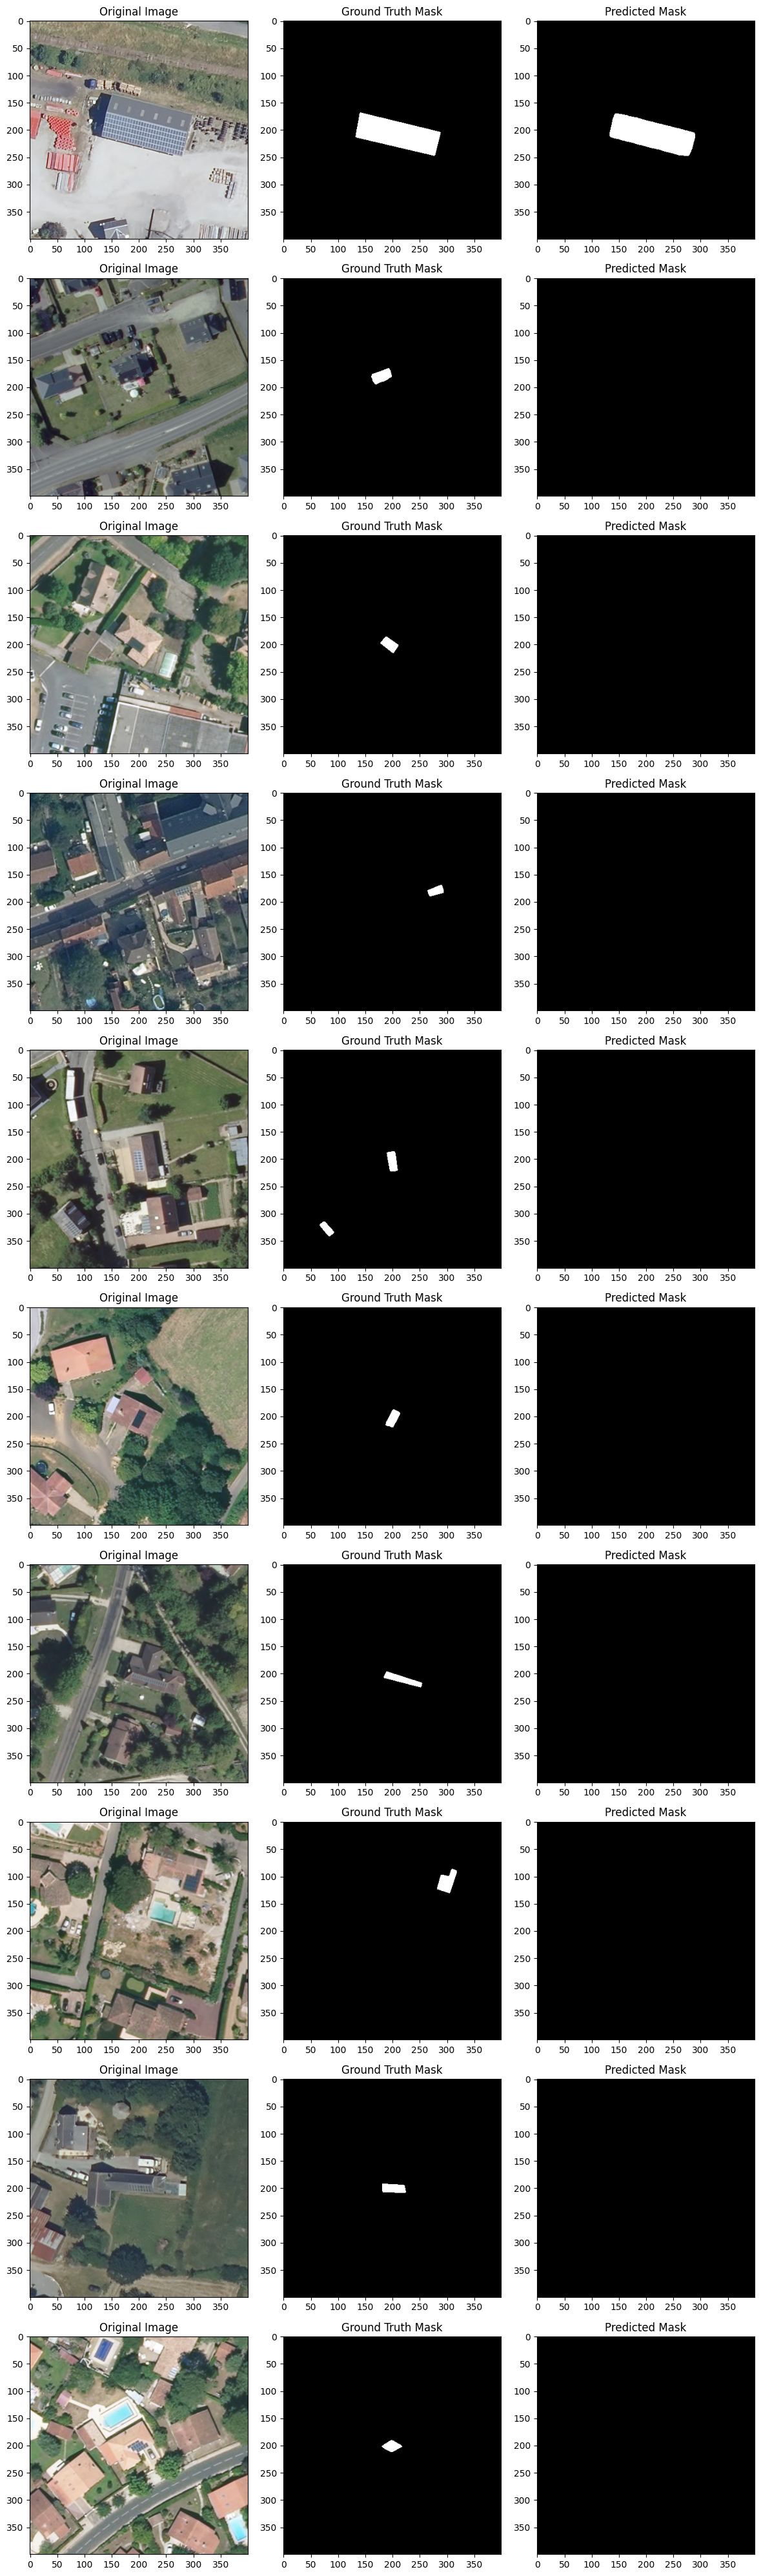

In [ ]:
visualize_predictions(model, test_dataset, num_images=10)

In [ ]:
average_dice = evaluate_dice(model, test_dataset)
print("Average DICE score:", average_dice)

Average DICE score: 0.5888441311817467
